In [ ]:
import gdown

# Downloading the Kaggle Dataset.
file_ids = ["1m99RBSAG4zIPOJ2nfRupHj-jZDteTr6G", "1p-bKN89n-r-HnDGRmVF2tDpvHA5DUv0w", "1XDBeNesyWO9YKVxh5fGtzQM4V-YXL_ZJ","1hakH4A1exZu58b8AEakkJFNktCGjMoAH","1Tf03LIjkD3GsLHO_meTUocIhdZ-uZHbM","1eInNXFn5ibTRT6R5P5ntn5jw8G-sWoPA","1YZymTI35b22W8Z_X371xAIYUWz7SztLW"]  # Add all file IDs here
destinations=["assessments.csv","courses.csv","studentAssessment.csv","studentInfo.csv","studentRegistration.csv","studentVle.csv","vle.csv"]
for i, file_id in enumerate(file_ids, 0):
    destination = f"file_{i}.csv"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, destinations[i], quiet=False)
    print(f"Downloaded: {destinations[i]}")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  # or .sum() if you prefer total score
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# 3.1 Merge total_assessments (on code_module + code_presentation)
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# 3.2 Merge attempted_assessments & average_score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# 3.3 Merge total_vle_clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Replace NaN with 0 if needed
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"] = df_merged["total_assessments"].fillna(0)
df_merged["score"] = df_merged["score"].fillna(0)  # if missing, assume 0 or handle differently
df_merged["total_vle_clicks"] = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment_completion_ratio safely
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# Filter out withdrawn
df_merged = df_merged[
    (df_merged["final_result"] != "Withdrawn") 
].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# ---------------------------
# Final DataFrame including module
# ---------------------------
df_final = df_merged[
    [
        "id_student",
        "code_module",            # <-- include the module feature here
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

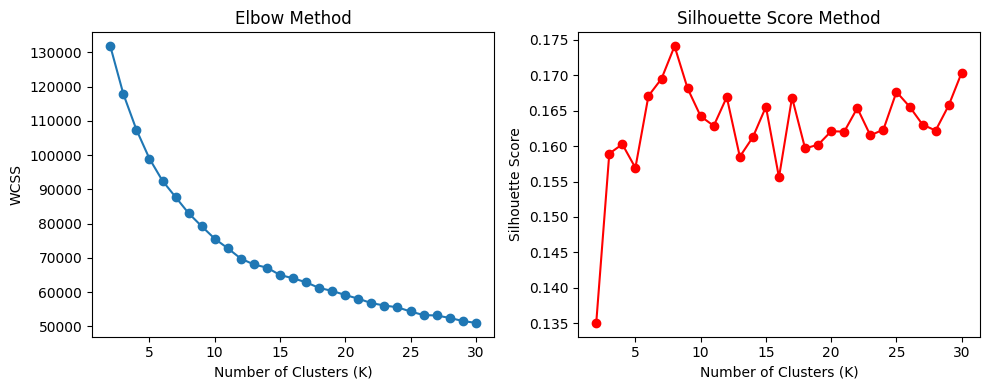

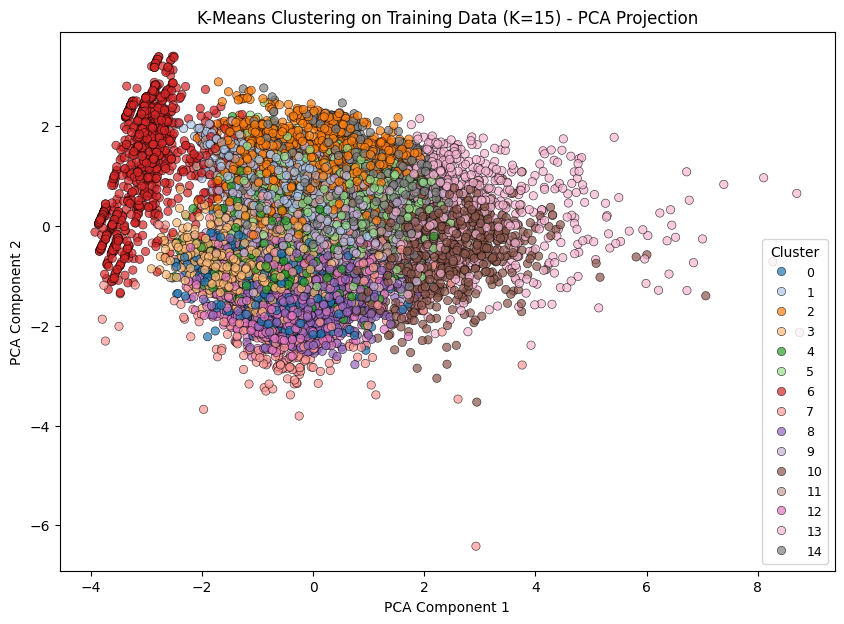

TRAINING SET CLUSTER MEANS:
         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           1.583933  72.043438  0.039568  2.041966  0.128297   0.000000   
1           5.680198  76.674101  0.000000  5.734653  1.276238   0.000000   
2           4.078635  72.447268  0.997033  5.789318  1.999011   0.007913   
3           1.436271  71.152530  0.012382  6.071377  1.944647   0.000000   
4           1.237875  73.093315  0.316397  5.717090  2.154734   1.028868   
5           4.029202  76.170001  0.971510  2.451567  0.170940   0.000000   
6           3.381924   3.228005  0.563654  6.137998  1.314869   0.270165   
7           3.043831  69.384337  0.527597  6.043831  0.907468   0.224026   
8           1.300799  76.250857  0.097604  5.943212  0.291925   1.008873   
9           3.357776  74.449470  1.000000  8.771733  0.164400   0.000591   
10          3.196989  76.011749  0.829360  5.890841  0.78544

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ===========================
# 1. Data Preprocessing and Train-Test Split
# ===========================

# Assume df_final is already loaded (same as in your code)
df = df_final.copy()

# Split into training and test sets (example: 75% train, 25% test)
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# -- Separate out the "target" column so it does not affect clustering --
train_target = train_df['target'].copy()
test_target = test_df['target'].copy()

# -- Also drop the student ID from clustering --
train_df.drop(columns=['id_student', 'target'], inplace=True)
test_df.drop(columns=['id_student', 'target'], inplace=True)

# ===========================
# 2. Encode Categorical Variables (TRAIN + TEST)
# ===========================

categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# ===========================
# 3. Standardize Features for Clustering
# ===========================

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

# ===========================
# 4. Finding Optimal K (on Training Only)
# ===========================

wcss = []
silhouette_scores = []
K_range = range(2, 31)  # e.g. 2 to 30

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(train_scaled)
    wcss.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(train_scaled, cluster_labels))

# Plot Elbow & Silhouette
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

plt.tight_layout()
plt.show()

# ===========================
# 5. Apply K-Means with Optimal K
# ===========================

optimal_k = 15  # For example
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit on TRAIN
train_clusters = kmeans.fit_predict(train_scaled)
train_df['Cluster'] = train_clusters

# Predict on TEST
test_clusters = kmeans.predict(test_scaled)
test_df['Cluster'] = test_clusters

# ===========================
# 6. (Optional) PCA for 2D Visualization
# ===========================

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

train_df['PCA1'] = train_pca[:, 0]
train_df['PCA2'] = train_pca[:, 1]

test_df['PCA1'] = test_pca[:, 0]
test_df['PCA2'] = test_pca[:, 1]

# ===========================
# 7. Re-attach Target
# ===========================

train_df['target'] = train_target
test_df['target'] = test_target

# ===========================
# 8. Visualize Training Clusters
# ===========================

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster',
    data=train_df,
    alpha=0.7, edgecolor="black",
    palette="tab20"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering on Training Data (K={optimal_k}) - PCA Projection")

# Adjust legend for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)
plt.show()

# ===========================
# 9. Display Cluster Statistics
# ===========================

print("TRAINING SET CLUSTER MEANS:")
print(train_df.groupby('Cluster').mean(numeric_only=True))

print("\nTEST SET CLUSTER MEANS:")
print(test_df.groupby('Cluster').mean(numeric_only=True))


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import clone

# ===========================
# Remove PCA1 & PCA2 columns
# ===========================
if 'PCA1' in train_df.columns:
    train_df.drop(columns=['PCA1'], inplace=True, errors='ignore')
if 'PCA2' in train_df.columns:
    train_df.drop(columns=['PCA2'], inplace=True, errors='ignore')

if 'PCA1' in test_df.columns:
    test_df.drop(columns=['PCA1'], inplace=True, errors='ignore')
if 'PCA2' in test_df.columns:
    test_df.drop(columns=['PCA2'], inplace=True, errors='ignore')

# or more succinctly:
# train_df.drop(columns=['PCA1','PCA2'], inplace=True, errors='ignore')
# test_df.drop(columns=['PCA1','PCA2'], inplace=True, errors='ignore')

# ===========================
# 1) Preprocessing for Modeling
# ===========================
# (Assuming the KMeans clustering code has been executed and both train_df and test_df include a 'Cluster' column)

# Ensure the Cluster column is categorical in both train and test sets.
train_df['Cluster'] = train_df['Cluster'].astype('category')
test_df['Cluster'] = test_df['Cluster'].astype('category')

# Define features including the KMeans cluster and module
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module', 'Cluster'  # <-- Using KMeans cluster as a feature
]

# Extract training and test features and target
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

# One-Hot Encode Categorical Features for both training and test sets
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module', 'Cluster']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns between training and test sets (fill missing columns with zeros)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Create sample weights based on module frequency (calculated from the training set)
module_counts = train_df['code_module'].value_counts()
train_df['module_weight'] = train_df['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = train_df['module_weight']

# Define Models using the Best Parameters
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_leaf=4,
        min_samples_split=2,
        class_weight='balanced',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        max_features=None,
        min_samples_leaf=4,
        min_samples_split=2,
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            class_weight='balanced',
            random_state=42
        ),
        n_estimators=200,
        learning_rate=0.01,
        random_state=42
    )
}

print("Preprocessing complete. Features and models are defined.")


Preprocessing complete. Features and models are defined.


c:\Users\chipp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


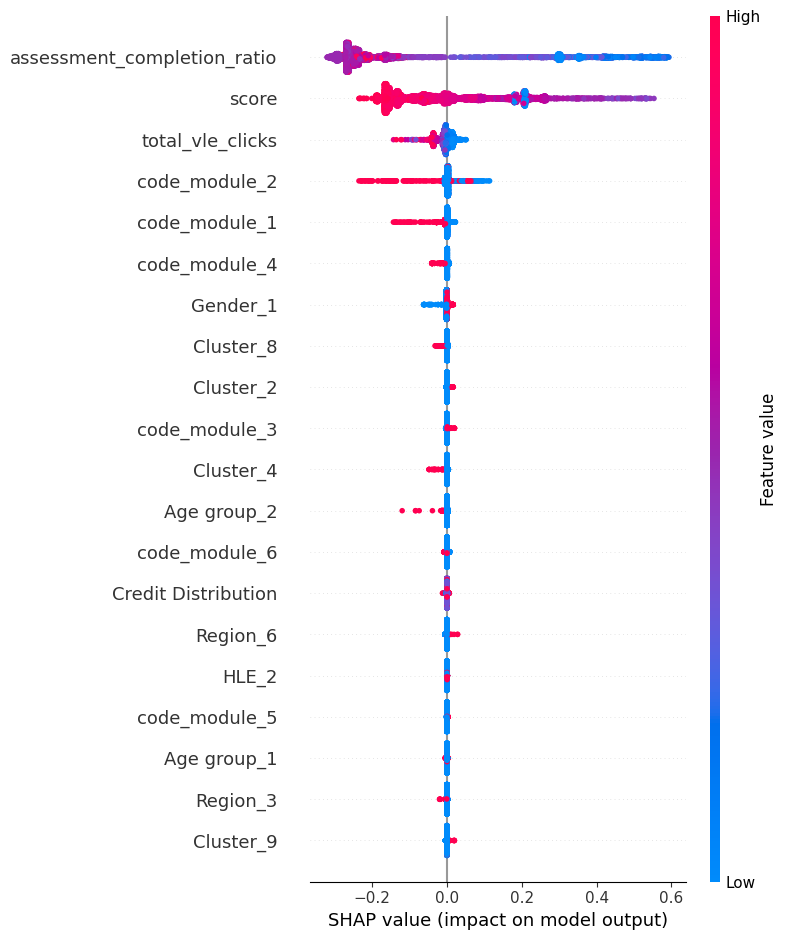

In [7]:
import shap

# Retrieve the RandomForest model from your models dictionary
rf_model = models["Random Forest"]

# Fit the model if it hasn't been already
rf_model.fit(X_train_encoded, y_train, sample_weight=sample_weights)

# Initialize the SHAP TreeExplainer with the fitted model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values on the test set
shap_values = explainer.shap_values(X_test_encoded)

# Plot the SHAP summary plot for the first output dimension.
shap.summary_plot(shap_values[:, :, 0], X_test_encoded, feature_names=X_test_encoded.columns)
